## 1. Setting Up the Environment and Configuring GPU Memory Growth

In this section, we begin by importing essential libraries that will be used throughout the project. We start by importing TensorFlow, which is a powerful library for machine learning and deep learning tasks.

Next, we ensure that the GPU memory usage is optimized. By default, TensorFlow might allocate all GPU memory, which can lead to out-of-memory (OOM) errors. To prevent this, we use the `tf.config.experimental.set_memory_growth()` function, which allows TensorFlow to allocate GPU memory as needed, growing the memory consumption only when required.

We also import `cv2` from OpenCV for image processing tasks and `imghdr` for image type checking. The `data_dir` variable is set to the path where the training dataset is stored, and `img_ext` contains a list of acceptable image file extensions.


In [9]:
# import tensorflow as tf
import os
#Avoid omm errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
import cv2
import imghdr
data_dir="D:\\Dataset\\dataset\\training_set"
img_ext = ['jpeg','jpg','bmp','png']
os.listdir(data_dir)

['cats', 'dogs']

## 2. Filtering and Validating Images

This code iterates through each image in the dataset directory, ensuring that only valid image files with the correct extensions are retained.
Using OpenCV, each image is read, and its file type is checked with `imghdr`.
If the file type doesn't match the allowed extensions, it is removed. Any issues encountered during processing are logged for review.

In [2]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_ext:
                print("Image not in ext{}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}",format(image_path))
            

## 3. Importing Libraries and Creating a Data Pipeline

In this section, we import `numpy` for numerical operations and `matplotlib.pyplot` for plotting and visualization tasks. We then create a data pipeline using TensorFlow's `image_dataset_from_directory()` method, which efficiently loads images from the specified directory. This dataset is then converted into an iterator to facilitate easy access to batches of data for model training or testing.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
data = tf.keras.utils.image_dataset_from_directory("D:\\Dataset\\dataset\\training_set") #creating the data pipeline
data_iterator = data.as_numpy_iterator() #access the data pipeline
batch = data_iterator.next()

Found 7122 files belonging to 2 classes.


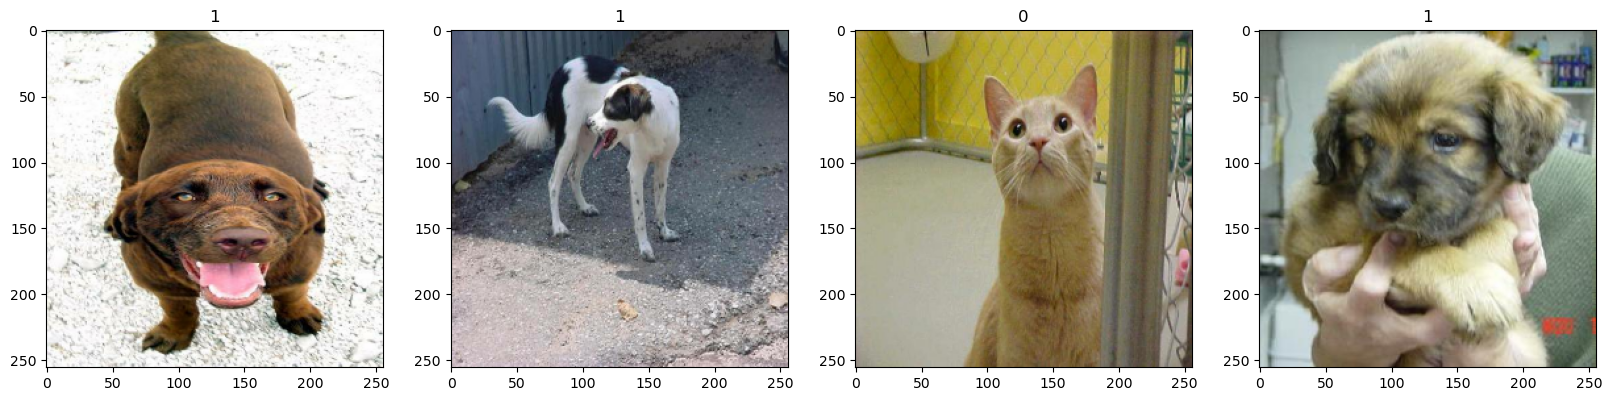

In [4]:
fig ,ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) #Dog is 1 and Cat is 0 (assigned binary values)

## 4. Preprocessing and Splitting the Data

This section focuses on preprocessing the image data and splitting it into training, validation, and test sets. 

First, the images are scaled by dividing the pixel values by 255, normalizing the data for better model performance. The `lambda` function is applied to each batch, where `x` represents the images and `y` represents the target variables (labels).

Next, the dataset is split into three parts: 
- **Training set** (70%): Used to train the model.
- **Validation set** (20%): Used to tune the model's hyperparameters.
- **Test set** (10%): Used to evaluate the model's performance.

The `take()` and `skip()` methods are used to partition the data accordingly.

In [5]:
#Preproceesing the data
#scale data
data = data.map(lambda x,y: (x/255,y)) #x = images , y= taget variables
batchh = data.as_numpy_iterator().next()

In [6]:
#Splitting the data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
teat = data.skip(train_size+val_size).take(test_size)

## 5. Building and Training the Deep Learning Model

In this section, we construct a Convolutional Neural Network (CNN) using TensorFlow's Keras API. The model is built using a `Sequential` architecture, which allows us to stack layers in sequence.

- **Convolutional Layers**: Three convolutional layers are added, each followed by a MaxPooling layer. The first layer uses 16 filters, while the second and third layers use 32 and 16 filters, respectively. The ReLU activation function is used to introduce non-linearity.
  
- **Flattening and Dense Layers**: After the convolutional layers, the output is flattened into a 1D array. A dense layer with 256 units and ReLU activation is added, followed by an output layer with a single unit and sigmoid activation, ideal for binary classification tasks.

- **Model Compilation**: The model is compiled with the Adam optimizer, binary cross-entropy loss function, and accuracy as a performance metric.

- **Model Training**: The model is trained over 10 epochs using the training dataset. Validation is performed using the validation dataset, and TensorBoard is used to log the training process for later visualization.


In [7]:
#Build Deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation = "relu", input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(1, activation= "sigmoid"))
model.compile("adam", loss = tf.losses.BinaryCrossentropy(), metrics = ["accuracy"])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)      

In [12]:
#Train the model
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
hist = model.fit(train, epochs = 10,validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/10
156/156 [==============================] - 40s 254ms/step - loss: 0.0174 - accuracy: 0.9960 - val_loss: 1.7776 - val_accuracy: 0.7319
Epoch 2/10
156/156 [==============================] - 44s 280ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 1.8052 - val_accuracy: 0.7292
Epoch 3/10
156/156 [==============================] - 38s 243ms/step - loss: 0.0112 - accuracy: 0.9978 - val_loss: 1.9015 - val_accuracy: 0.7264
Epoch 4/10
156/156 [==============================] - 38s 243ms/step - loss: 0.0132 - accuracy: 0.9978 - val_loss: 1.9041 - val_accuracy: 0.7278
Epoch 5/10
156/156 [==============================] - 38s 241ms/step - loss: 0.0151 - accuracy: 0.9976 - val_loss: 1.7935 - val_accuracy: 0.7368
Epoch 6/10
156/156 [==============================] - 40s 252ms/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 2.0371 - val_accuracy: 0.7292
Epoch 7/10
156/156 [==============================] - 40s 254ms/step - loss: 0.0426 - accuracy: 0.9870 - val_loss: 1.3896 - val_ac

## 6. Plotting Model Performance

After training the model, it's important to visualize the performance metrics to evaluate how well the model is learning. 

- **Loss Curves**: The first plot shows the training and validation loss over the epochs. This helps in understanding how well the model is minimizing the error during training and whether it is overfitting or underfitting.

- **Accuracy Curves**: The second plot displays the training and validation accuracy over the epochs. This visualization indicates how well the model is correctly predicting the classes during training and validation.

The plots are labeled and titled appropriately for clear interpretation.

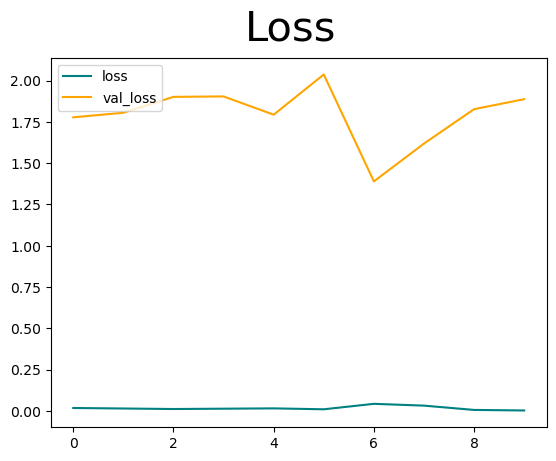

In [13]:
#Plot performance
fig = plt.figure()
plt.plot(hist.history['loss'], color = "teal", label= "loss")
plt.plot(hist.history["val_loss"], color = "Orange", label = "val_loss")
fig.suptitle("Loss", fontsize = 30)
plt.legend(loc="upper left")
plt.show()

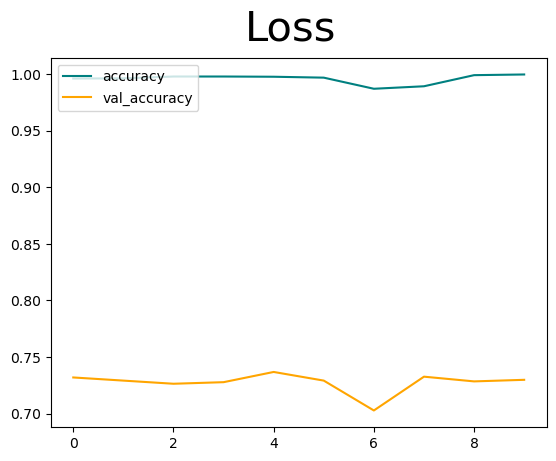

In [14]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = "teal", label= "accuracy")
plt.plot(hist.history["val_accuracy"], color = "Orange", label = "val_accuracy")
fig.suptitle("Loss", fontsize = 30)
plt.legend(loc="upper left")
plt.show()


## 7. Evaluating Model Performance

In this section, we evaluate the trained model on the test dataset using key performance metrics:

- **Precision**: Measures the proportion of true positive predictions among all positive predictions.
- **Recall**: Assesses the proportion of true positives correctly identified by the model.
- **Binary Accuracy**: Calculates the proportion of correct predictions (both true positives and true negatives).

The test dataset is iterated through, and predictions are made using the model. The `Precision`, `Recall`, and `BinaryAccuracy` metrics are updated with each batch of predictions, and the final results are printed.

In [15]:
#Evaluate performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy 
pre = Precision()
re = Recall()
acc= BinaryAccuracy()
for batch in teat.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

1/1 [==============================] - 0s 85ms/step
Precision:0.6758794188499451, Recall:0.7598869800567627, Accuracy:0.6898550987243652


## 8. Making Predictions on New Images

In this section, we demonstrate how to use the trained model to make predictions on a new image.

- **Image Loading and Resizing**: The image is loaded using OpenCV and resized to the required input dimensions (256x256 pixels) using TensorFlow's `tf.image.resize()` function.

- **Prediction**: The image is then normalized by dividing pixel values by 255, expanded into a batch format, and fed into the model for prediction. The model outputs a probability score indicating the likelihood of the image belonging to a particular class.

- **Class Decision**: Based on the prediction, if the probability is greater than 0.5, the image is classified as "Dog"; otherwise, it is classified as "Cat".

In [16]:
import cv2
img = cv2.imread("D:\\Testing\\Dog2.jpg")
resize = tf.image.resize(img,(256,256))

In [17]:
prediction = model.predict(np.expand_dims(resize/255,0))
print(prediction)
if prediction> 0.5:
    print("Dog")
else:
    print("Cat")

1/1 [==============================] - 0s 22ms/step
[[0.94601226]]
Dog
